# OzGrav Winter School - 2023

### Gravitational Wave parameter estimation using neural network

### Chayan Chatterjee (chayan.chatterjee@research.uwa.edu.au)

In this workshop, we are going to explore the application of neural networks for parameter estimation of gravitational waves. For simplicity, we are only going to estimate the chirp mass and mass ratio parameters. We will assume that the joint posterior distribution of the parameters can be modelled as a multi-variate Gaussian with a diagonal covariance matrix.

The main advantage of using neural networks is its inference speed and expressivity -- posterior distributions of any arbitrary complex shapes can be estimated in a few seconds. In comparison, standard parameter estimation methods, based on iterative sampling methods like Markov Chain Monte Carlo and Nested Sampling can take hours to days. For an introduction to standard parameter estimation methods check out Dr. Rory Smith's inference workshop notebooks and slides from OzGrav Winter School - 2022: https://github.com/rory-smith/Lectures-on-inference-in-GW-astronomy/tree/master

# Importing necessary packages

In [1]:
from pycbc.waveform import get_td_waveform, td_approximants
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import FrequencySeries
import numpy as np
import matplotlib.pyplot as plt
import lal
import corner
import h5py


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


# Generate training data

Since we are only estimating the chirp mass and mass ratio, we will only sample the component masses for generating our waveforms, instead of all 15 parameters describing a gravitational wave signal. The chirp mass and mass ratio are given by:

$$
\text{Chirp mass}, \; m_{chirp} = \frac{(m_{1}m_{2})^{3/5}}{(m_{1} + m_{2})^{1/5}}
$$

$$
\text{Mass ratio}, \; q = \frac{m_{2}}{m_{1}}, \; \text{where} \; m_{1} > m_{2}.
$$


In [3]:
num_samples = 10000  # size of the training set

m_lower = 20.0  # in solar masses
m_upper = 80.0
masses = m_lower + np.random.random((num_samples, 2)) * (m_upper - m_lower)

# Make sure m1 > m2
masses = np.sort(masses, axis=-1)
masses = np.flip(masses, axis=-1)


In [4]:
masses

array([[64.59825906, 46.75631434],
       [45.22898179, 24.86349267],
       [66.84565177, 55.55304421],
       ...,
       [29.79358487, 23.48432629],
       [71.69395403, 52.65965787],
       [66.08144509, 30.97870935]])

In [5]:
# Fixed parameters

distance = 1000  # in Mpc
inclination = 0.0  # assuming all binaries are face on relative to the detectors
spin1x = 0.0
spin1y = 0.0
spin1z = 0.0
spin2x = 0.0
spin2y = 0.0
spin2z = 0.0
phase = 0.0


We will generate time-domain waveforms using the 'IMRPhenomD' family of approximants. For this exercise, we will only work with 1 sec long single detector waveforms.

We will set the frequency range between 30 - 2048 Hz. A lower minimum frequency threshold will result in longer waveforms since the signal can then be tracked in the detector for larger number of cycles.

In [6]:
# Waveform settings

approximant = 'IMRPhenomD'
f_lower = 30.0
f_final = 2048.0
T = 1 # length of signal
sampling_rate = 2048.0

delta_f = 1 / T
delta_t = 1/sampling_rate
nf = int(f_final / delta_f)
f_array = np.linspace(f_lower, f_final, num=nf) # defining a frequency range


# Generate the noise Power Spectral Density

We will consider the 'Advanced LIGO Zero-Detuned High Power' PSD. Different PSDs can be chosen based on the desired detector configuration. A list of all available PSDs in pycbc.psd package can be found here: https://pycbc.org/pycbc/latest/html/pycbc.psd.html. 

Note that the PSDs from lalsimulation are computed at the required frequencies by interpolating a fixed set of samples. If the required frequencies fall outside of the range of the known samples no warnings will be raised, and (meaningless) extrapolated values will be returned.


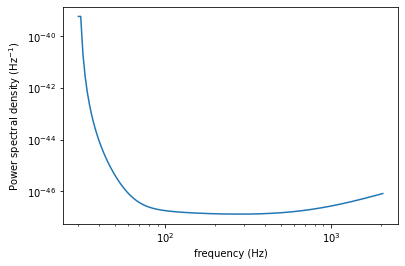

In [7]:
# Noise PSD

psd = np.array(aLIGOZeroDetHighPower(nf, delta_f, 0.0))
psd[0] = psd[1]  # Adjusting the endpoints
psd[-1] = psd[-2]

asd = np.sqrt(psd) # calculating the amplitue spectral density

# Plotting the PSD

plt.yscale('log')
plt.xscale('log')

plt.xlabel('frequency (Hz)')
plt.ylabel('Power spectral density (Hz$^{-1}$)')
plt.plot(f_array, psd)


# Generate the waveforms

The GW waveform as received by the detectors is given by the combination of the + and x cross polarizations of the wave and the detector response, specified by the antenna beam pattern functions of the detector, F$_{+}$ and F$_{\times}$. 

$$
h(t) = F_{+}(\theta, \phi, \psi; t)h_{+}(t) + F_{\times}(\theta, \phi, \psi; t)h_{\times}(t)
$$

The antenna beam patterns are functions of three Euler angles $(\theta, \phi, \psi)$ and a reference GPS time, which together define the position and orientation of the detector with respect to the source. In this exercise, we will fix the detector-source orientation for all the waveforms. 

In [8]:
from pycbc.detector import Detector

f_plus, f_cross = Detector('H1').antenna_pattern(right_ascension=3.42695494,
                                     declination=-0.40526058,
                                     polarization=0.0,
                                     t_gps=1187008882.4) # We are using RA, Dec and t_gps of GW170817


Generating waveforms will take about a minute on OzStar.

If you are using your personal laptop, you may skip this step and directly read the data from the 'Waveforms.hdf' file by running the next cell.


In [9]:
# Generate training waveforms

from tqdm import tqdm

signal = []

length = int(T*sampling_rate)

for i in tqdm(range(num_samples)):
    
    mass1, mass2 = masses[i]
    
    hp, hc = get_td_waveform(approximant=approximant,
                             mass1=mass1, mass2=mass2,
                             inclination=inclination,
                             distance=distance,
                             coa_phase = phase,
                             spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,
                             spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,        
                             delta_t=delta_t,
                             delta_f=delta_f,
                             f_lower=f_lower, f_final=f_final)
    
    detector_signal = f_plus * hp + f_cross * hc
    
    detector_signal.resize(length)
    
    # Whiten waveforms and rescale so that white noise has unit variance
    detector_signal = detector_signal/(100*asd* np.sqrt(4.0 * delta_f))
    
    signal.append(detector_signal)

signal = np.array(signal)


In [10]:
#f1 = h5py.File('Waveforms.hdf', 'r')
#signal = f1['signals'][()]
#masses = f1['parameters'][()]
#f1.close()


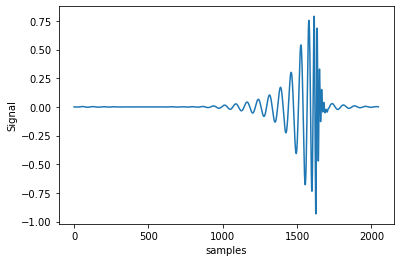

In [11]:
# Sample waveform

plt.plot(signal[0])
plt.xlabel('samples')
plt.ylabel('Signal')
#plt.xlim((10, f_final))
plt.show()


In [12]:
masses[0]


array([72.57206108, 54.44681087])

In [13]:
# Defining chirp mass and mass ratio from the component masses.

m1 = masses[:, 0]
m2 = masses[:, 1]

Mc = (m1 * m2)**(3/5) / (m1 + m2)**(1/5)
q = m2 / m1

parameters = np.stack((Mc, q), axis=1).astype(np.float32)


In [14]:
# For best training, parameters should be standardized (zero mean, unit variance across the training set)

parameters_mean = np.mean(parameters, axis=0)
parameters_std = np.std(parameters, axis=0)

parameters_standardized = (parameters - parameters_mean) / parameters_std


In [15]:
# Convert the data and labels into TensorFlow tensors

signals_tensor = tf.convert_to_tensor(signal)
parameters_tensor = tf.convert_to_tensor(parameters_standardized)


In [16]:
# Create a Dataset object from the data and labels tensors
dataset = tf.data.Dataset.from_tensor_slices((signals_tensor, parameters_tensor))


# Add Gaussian noise to signals

In [17]:
def preprocess_data(waveform, params):
       
    noise = 0.1*np.random.normal(size = waveform.shape).astype(np.float32)
    strain = waveform + noise
    
    return strain, params


In [18]:
train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train

# Applying necessary transformations to the data
dataset = dataset.map(preprocess_data, num_parallel_calls=5)
dataset = dataset.shuffle(num_samples)

# Split the dataset into training and test sets
train_dataset = dataset.take(num_train)
test_dataset = dataset.skip(num_train)


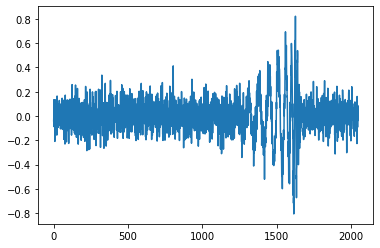

In [19]:
strain, params = list(train_dataset.as_numpy_iterator())[0]

plt.plot(strain)


# Construct the neural network

TensorFlow provides different APIs for building neural networks. These APIs differ in the level of abstraction they provide to the underlying Python code. Here we will use the tf.keras API. 

Keras is an open-source deep learning library written in Python. The project was started in 2015 by Francois Chollet. It quickly became a popular framework for developers because the API was clean and simple, allowing standard deep learning models to be defined, fit, and evaluated in just a few lines of code.

We will use Subclassing to construct our neural network. Subclassing provides a fully-customizable way of defining neural networks and enables us to implement your own custom forward-pass of the model, but requires more coding. Other simpler ways of defining neural networks are by using the Sequential and Functional API. A description of these methods can be found here: https://pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/



In [20]:
class NeuralNetwork(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(32, activation='relu', kernel_initializer="lecun_normal") 
                       for _ in range(5)]
        
        self.output_mean = tf.keras.layers.Dense(output_dim)
        self.output_log_sigma = tf.keras.layers.Dense(output_dim)
        
        
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
            
        # Output layer defines a Gaussian
        mean = self.output_mean(Z)
        log_sigma = self.output_log_sigma(Z)
        sigma = tf.exp(log_sigma)
        
        # Create the Gaussian distribution
        dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
        
        return dist
            

In [21]:
# Get the shape of the first element in the dataset
output_dim = list(next(iter(parameters_tensor)).shape)[0]

model = NeuralNetwork(output_dim)


In [22]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = "-".join(["{}: {:.4f}".format(m.name, m.result())
                       for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} -".format(iteration, total) + metrics, end=end)
    

# Define the training loop

In [23]:
@tf.function
def train(data, model, optimizer):
    
    train_loss = 0.0
    average_loss = 0.0
    size = len(data)
    
    for batch, (X_batch, y_batch) in enumerate(data):
        with tf.GradientTape() as tape: #  tf.GradientTape() captures the gradients during this step.
            dist = model(X_batch)
            loss = -tf.reduce_mean(dist.log_prob(y_batch)) # Compute log-likelihood loss
            
        gradients = tape.gradient(loss, model.trainable_variables) #  Applying the gradients and change the weights.
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        train_loss += loss
        
        if batch % 50 == 0:
             tf.print('Loss:', loss)
                
    average_loss = train_loss / float(size)
    tf.print('Average loss:', average_loss)

    return average_loss
            

In [24]:
batch_size = 32
n_steps = num_train//batch_size
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
train_dataset = train_dataset.shuffle(buffer_size=10).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=10).batch(batch_size)

epochs = 50
train_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train(train_dataset, model, optimizer)
    train_history.append(loss)
print("Done!")


Epoch 1
-------------------------------
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Loss: 2.84472299
Loss: 2.56642818
Loss: 2.4186759
Loss: 2.28440189
Loss: 1.84896159
Average loss: 2.21580338
Epoch 2
-------------------------------
Loss: 1.28934336
Loss: 0.768016934
Loss: 0.767766058
Loss: 0.222612828
Loss: 0.0105521604
Average loss: 0.540866673
Epoch 3
-------------------------------
Loss: -0.284009188
Loss: 0.590843797
Loss: -0.220676571
Loss: -0.599982858
Loss: -0.488477141
Average loss: -0.231700167
Epoch 4
-------------------------------
Loss: 0.0980514139
Loss: -0.738897
Loss: -0.590343237
Loss: -0.351385176
Loss: -0.295456648
Average loss: -0.473301977
Epoch 5
-------------------------------
Loss: -0.68776989
Loss: -0.0443159491
Loss: -0.479049414
Loss: -0.455350131
Loss: -0.719375849
Average loss: -0.559552
Epoch 6
-------------------------------
Loss: -0.590360522
Loss: -0.862445
Loss: -0.759083569
Loss: -0.609972239
Loss: -0.7142496

Average loss: -1.61692917
Done!


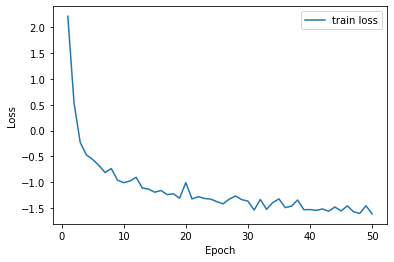

In [25]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluate using the trained model

In [26]:
num_posteriors = 10
num_samples = 10000

pred_samples = []
truth = []

for batch, (X,y) in enumerate(test_dataset):

    # Predict a posterior
    dist = model(X)

    # Sample the posterior
    samples = dist.sample((10000,))

    # Undo the standardization
    pred_samples.append(parameters_std * samples + parameters_mean)
    truth.append(parameters_std * y + parameters_mean)
 

# Make corner plots

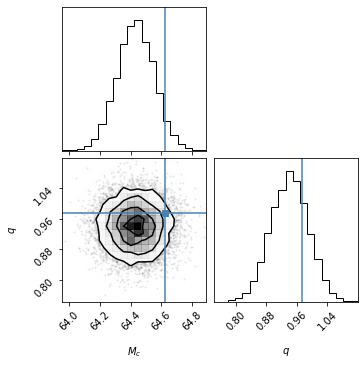

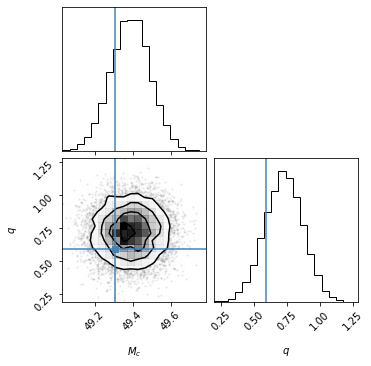

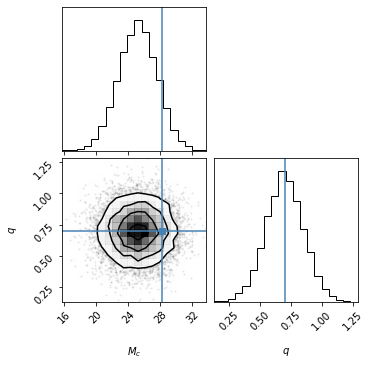

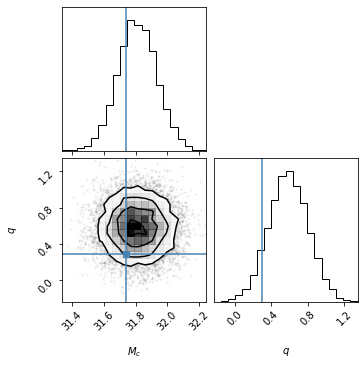

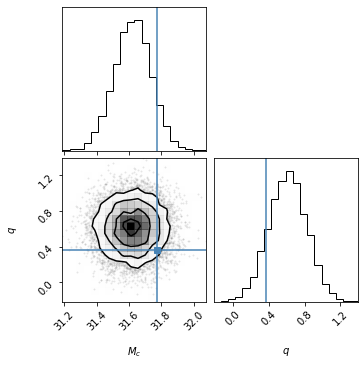

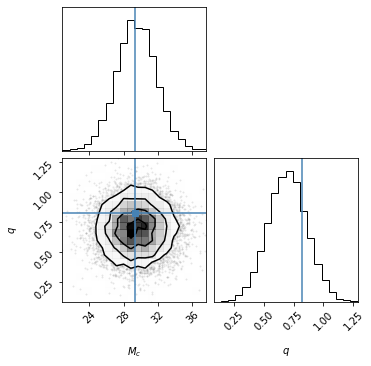

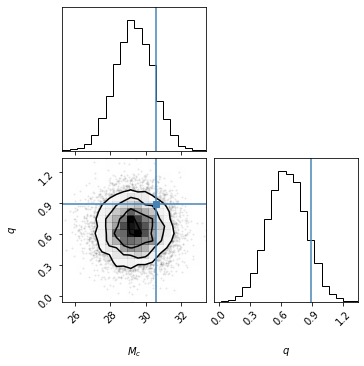

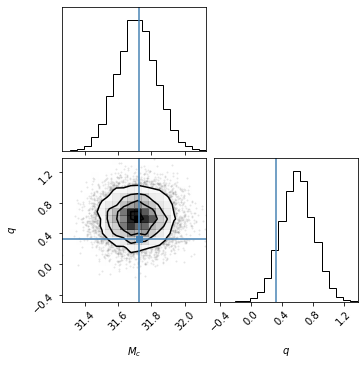

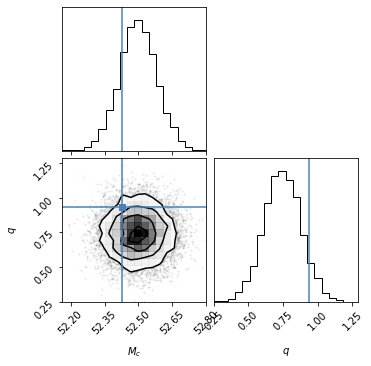

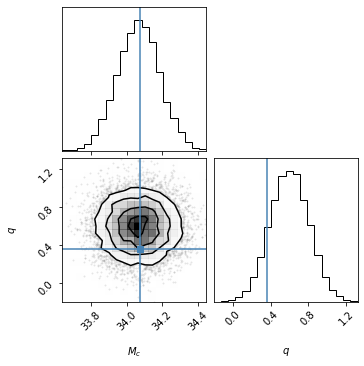

In [27]:
for i in range(num_posteriors):
    
    corner.corner(pred_samples[i][:,i,:].numpy(), truths=truth[i][i].numpy(), labels=['$M_c$', '$q$'])
    plt.show()
    

# Challenges!


1. Improve the performance of the network by adjusting number of layers, neurons. If possible, add more training data.

2. Experiment with different optimizers - Adam, SGD and learning rate - 10^-3, 10^-2, 10^-5.

3. Add more parameters.

4. Use a fraction of the training dataset as a validation set. Adjust the training loop to monitor the validation loss alongwith the training loss.

5. Change the posterior model to a Gaussian with general covariance (Hint: check tfp.distributions.MultivariateNormalTriL: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalTriL)
